# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [2]:
%load_ext autoreload

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [4]:
# !/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install sentencepiece

In [5]:
pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import numpy as np
from dataset import TextDataset

In [7]:
train_set = TextDataset(data_file='/Users/vsevolodparamonov/Downloads/jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='/Users/vsevolodparamonov/Downloads/jokes.txt', train=False, sp_model_prefix='bpe')

In [8]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [17]:
from model import LanguageModel

In [18]:
model = LanguageModel(train_set)

In [19]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

tensor(67)
tensor(34)
tensor(0)
tensor(0)
tensor(0)


## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [ ]:
from train import train
from torch.utils.data import DataLoader
from torch import nn, optim

train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=train_set.pad_id)

train(model, optimizer, None, train_loader, val_loader, 10, num_examples=5)

Training 1/10:   0%|          | 0/3586 [00:00<?, ?it/s]

tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


KeyboardInterrupt: 

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

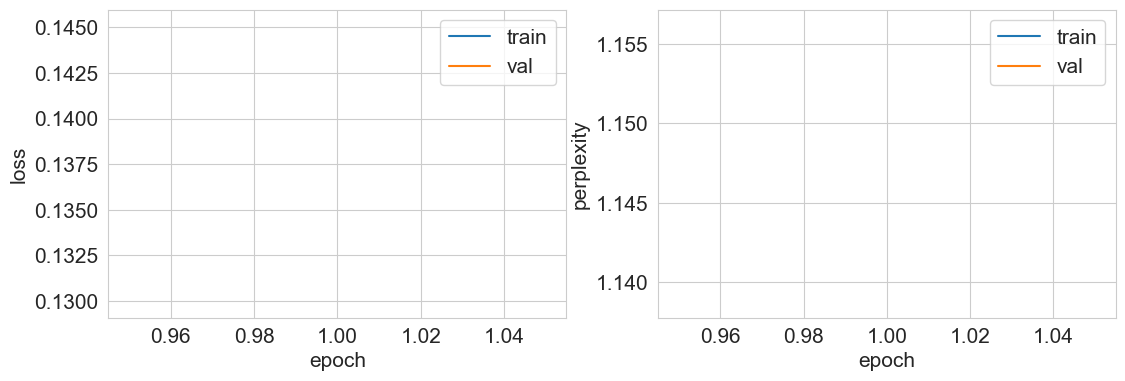

Generation examples:


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [12]:
model_lstm = LanguageModel(train_set, rnn_type=nn.LSTM)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)
train(model_lstm, optimizer, None, train_loader, val_loader, 10, num_examples=5)

Если не обращать внимание на переобучение у rnn (посмотреть на 9 эпоху), то ошибка у rnn - 0.125, у LSTM - 0.12
тексты, которые генерирует LSTM так же выглядят получше, в них меньше несуществующих слов, предложения более осмыслены. Поэтому дальше я использую именно эту модель.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [28]:
for temp in [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.5, 1.7, 2]:
    print('temp', temp)
    print(model_lstm.inference(prefix='', temp=0.5))

temp 0.1
- в нашем доме не познакомился. 
temp 0.2
- это когда он поручил всего лишь один из подчиненных отношений. 
temp 0.4
- не волнуйтесь. 
temp 0.6
- это когда ты жил на них убирать с ним в понедельник. 
temp 0.8
- это когда ты где-то необходимо пригласить к стоматологу? 
temp 1
у нас нет в мире на повышение пенсионного возраста, которые и не поднял. 
temp 1.2
- это когда я пошел в потребление к себе в голову. 
temp 1.5
- это как я просто замкнулся на мою машину, а она - жаль, что он работает! 
temp 1.7
- это когда ты не выйдет. 
temp 2
- в детстве я в постели не могу понять, что все повысили на кухне. 


Лучшие предложения получаются при температуре близкой к 1.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

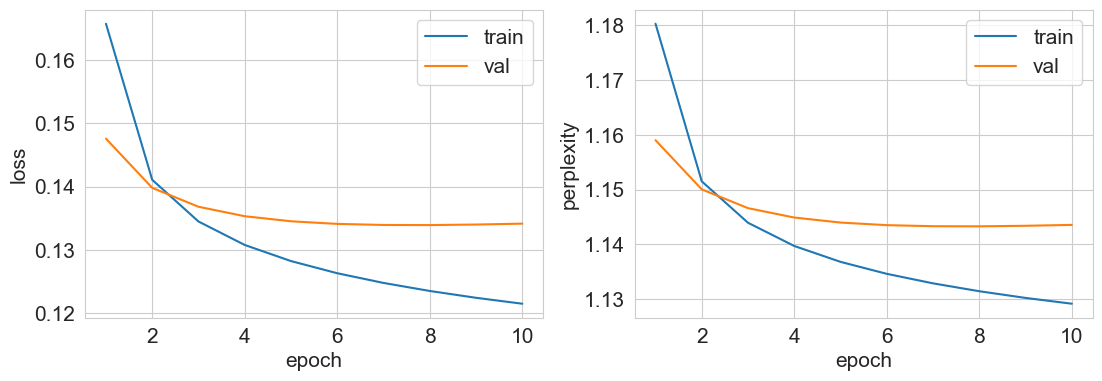

Generation examples:
в армии увидел обандерытам. 
мент у медсест- заяц надо поздравили!- доченька днк - ничего! если в жизни - получишь бреверности. 
в аптеке.- а тебя в форме не требуют?- потому что она нравится. а если хорошо информатиюдушкой по цеху, ставлю в речке, тащик становится для полной кафедрой. 
- как волкский врач?- брата.- у нас поймала на белой земле и мощный, сидя к обыствует тысяч с женой.- тебя, стона? почему так дешевое, еще одна и симпатичная?- просыпаемся.- нет вас в офисницу. 
сначала делают стук и звонит своему мужу- я люблю умила?- ну, у тебя нет глаз, ногами, все мужчины - он не слишком глубоко развестись. 


In [13]:
train_set_big = TextDataset('jokes.txt', train=True, vocab_size=5000, sp_model_prefix='bpe_big')
train_set_uni = TextDataset('jokes.txt', train=True, model_type='unigram', sp_model_prefix='unigram')
val_set_big = TextDataset('jokes.txt', train=False, vocab_size=5000, sp_model_prefix='bpe_big')
val_set_uni = TextDataset('jokes.txt', train=False, model_type='unigram', sp_model_prefix='unigram')

train_loader_big = DataLoader(train_set_big, batch_size=32, shuffle=False)
train_loader_uni = DataLoader(train_set_uni, batch_size=32, shuffle=False)
val_loader_big = DataLoader(val_set_big, batch_size=32, shuffle=False)
val_loader_uni = DataLoader(val_set_uni, batch_size=32, shuffle=False)

model_big = LanguageModel(train_set_big, rnn_type=nn.LSTM)
optimizer = optim.Adam(model_big.parameters(), lr=0.001)

train(model_big, optimizer, None, train_loader_big, val_loader_big, 10, num_examples=5)

Не очень правильно их сравнивать из-за разницы в количестве токенов. У bpe перплексия будет изначально ниже.

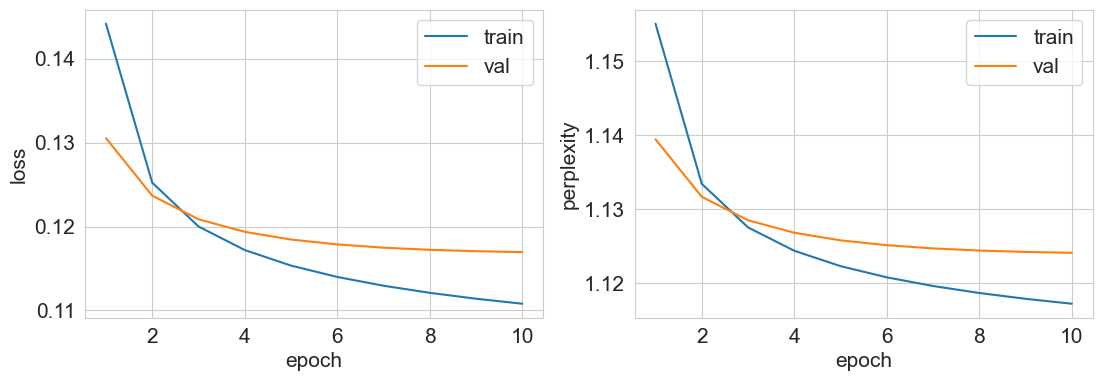

Generation examples:
водка упадет. 
чек изобретения, это журналисту тянет кошкам. 
страшно покурить и украспри рыбу не расходующего рутилина противоруска дебилов. 
- дорогая, что мой знаменит ваша жена бетаха?- понятия на мои математике латкого пишу.шоу из-за нежной авистор, и конюхатинца госдуме- да вас наверное говорит! 
гулянском! 


In [14]:
model_uni = LanguageModel(train_set_uni, rnn_type=nn.LSTM)
optimizer = optim.Adam(model_uni.parameters(), lr=0.001)

train(model_uni, optimizer, None, train_loader_uni, val_loader_uni, 10, num_examples=5)

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def calc_similarity(func_model, validate_set):
    texts = []
    for i in range(len(validate_set.texts)):
        generated_text = func_model.inference('', 0.8)
        texts += [generated_text]

    val_text = validate_set.text2ids(validate_set.texts)
    val_text = validate_set.ids2text(val_text)
    texts += val_text

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    svd_model = TruncatedSVD(n_components=3)
    reduced_tfidf_matrix = svd_model.fit_transform(tfidf_matrix)

    gen_text = reduced_tfidf_matrix[:len(valid_set.texts)]
    valid_texts = reduced_tfidf_matrix[len(valid_set.texts):]

    similarities = cosine_similarity(gen_text, valid_texts)

    max_vector = np.max(similarities, axis=1)

    return np.mean(max_vector), similarities

In [16]:
val, similarities_rnn = calc_similarity(model, valid_set)

print('For base rnn model:', val)

val, similarities_LSTM = calc_similarity(model_lstm, valid_set)

print('For base LSTM model:', val)

val, similarities_big = calc_similarity(model_big, val_set_big)

print('For big LSTM model:', val)

val, similarities_uni = calc_similarity(model_uni, val_set_uni)

print('For unigram LSTM model:', val)

For base rnn model: 0.9970555061628759
For base LSTM model: 0.9996295229377639
For big LSTM model: 0.9998862750043935
For unigram LSTM model: 0.9990482983807214


### плюсы
Симантическая близость текстов - довольно комплексный, хоршоший метод сравнения

### минусы
tf-idf и svd занимают время и ресурсы(
    
выбор n_components для svd сильно влияет на результаты, что плохо 

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



def make_plot(similar):

    tsne_model = TSNE(n_components=2, perplexity=min(30, len(similar)-1), random_state=42)

    similar = np.array(similar)
    reduced_vectors = tsne_model.fit_transform(similar)

    num_texts = reduced_vectors.shape[0] // 2

    plt.figure(figsize=(10, 8))

    plt.scatter(reduced_vectors[:num_texts, 0], reduced_vectors[:num_texts, 1], color='blue', label='Generated Texts')

    plt.scatter(reduced_vectors[num_texts:, 0], reduced_vectors[num_texts:, 1], color='red', label='Validation Texts')

    plt.legend()
    plt.title('t-SNE of Generated and Validation Texts')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

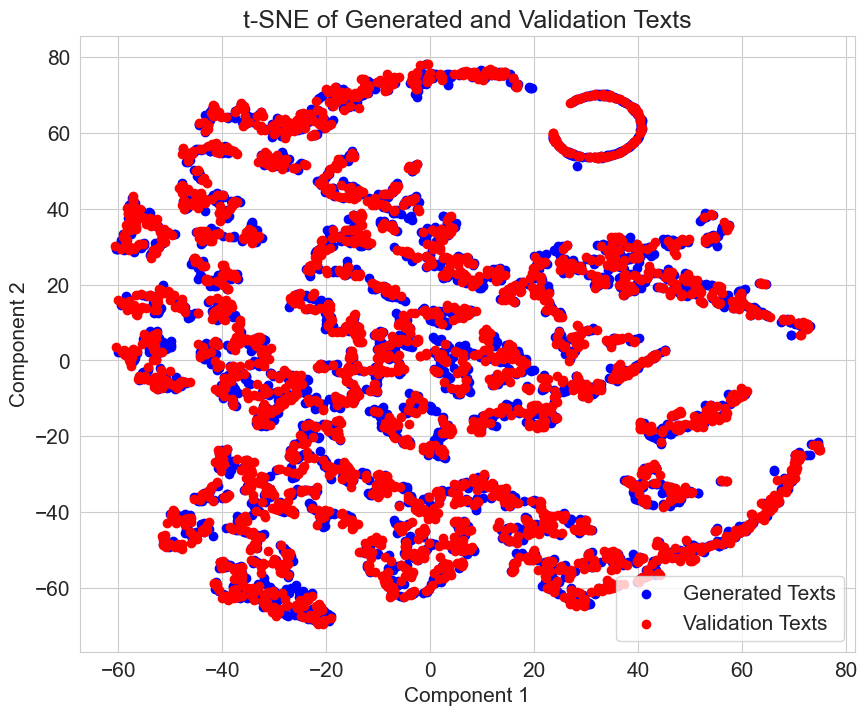

In [18]:
make_plot(similarities_rnn)

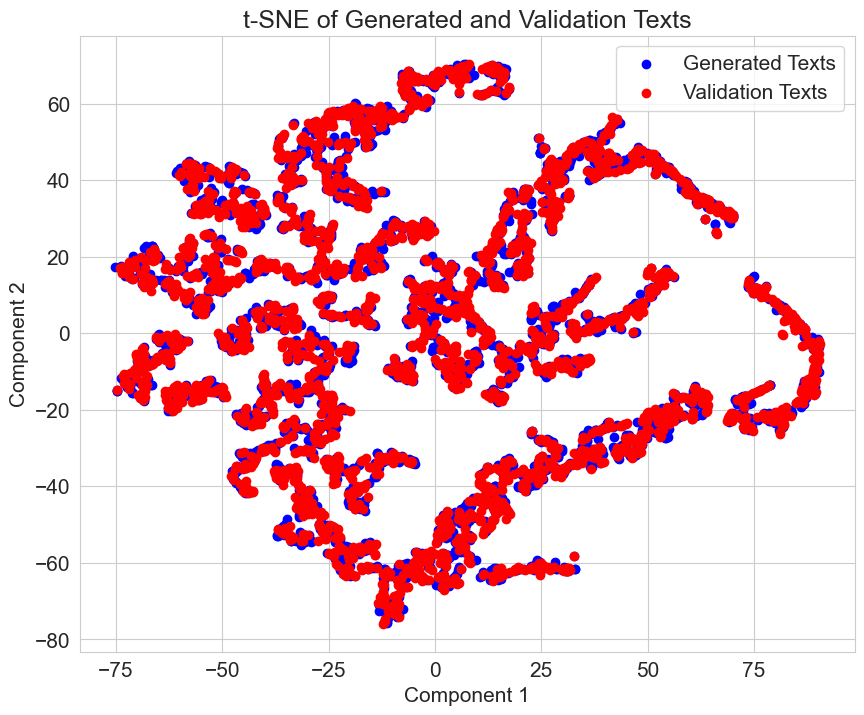

In [19]:
make_plot(similarities_LSTM)

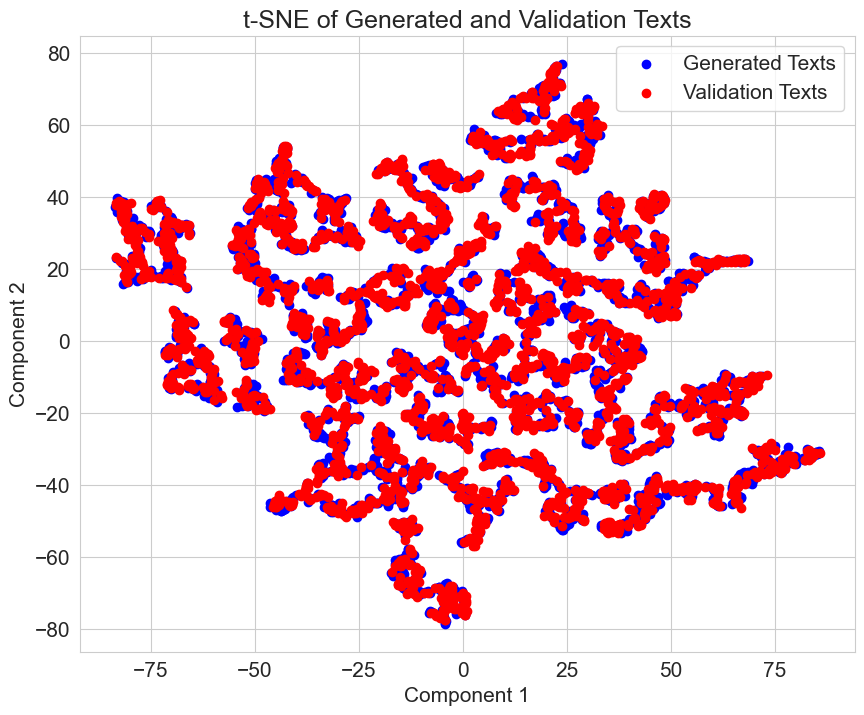

In [20]:
make_plot(similarities_big)

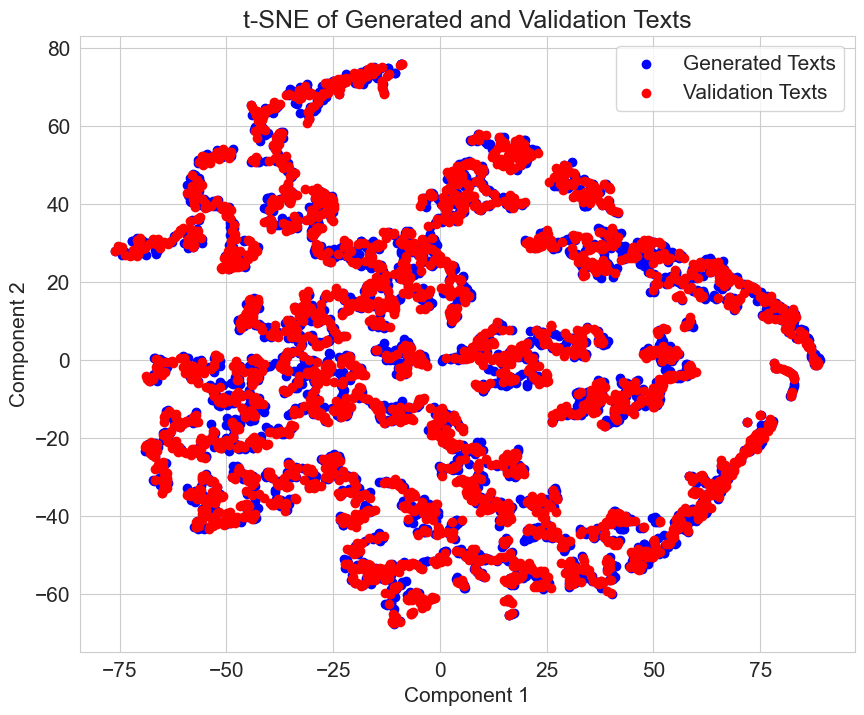

In [21]:
make_plot(similarities_uni)

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [22]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/opt/homebrew/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [23]:
def calculate_perplexity(text):
    encodings = tokenizer(text, return_tensors="pt")

    input_ids = encodings.input_ids
    attention_mask = encodings.attention_mask

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        log_likelihood = outputs[0].item()

    perplexity = torch.exp(torch.tensor(log_likelihood / input_ids.size(1))).item()
    return perplexity

In [24]:
lstm_text = model_lstm.inference('', 0.8)
big_text =  model_big.inference('', 0.8)
uni_text =  model_uni.inference('', 0.8)

In [25]:
print(lstm_text)
print('------------')
print(big_text)
print('------------')
print(uni_text)

если пытаться познакомиться? 
------------
- татуировки, гопоковому и о погоде прединые голубцы.- это от минет с дошло?- да нет, гладиаторвик, но даже не подозревала, что это была офигенно учебного подера. 
------------
- ты подняла покупку собаки.- потому что ты не можешь пересчитать. 


In [26]:
print('lstm', calculate_perplexity(lstm_text))
print('big', calculate_perplexity(big_text))
print('uni', calculate_perplexity(uni_text))

lstm 3.5733377933502197
big 1.147687554359436
uni 1.5059212446212769


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Вот:

заходит как-то в бар и говорит мужу- я хочу купить себе яйца!- ты что, охренительный?- а что ты тут делаешь?- да, я не знал, что у меня нет ни одной налоговой. 

Вот еще немного умных мыслей:

- в россии - это не означает, что он не догадывается.

- не волнуйтесь. 

- это когда я пошел в потребление к себе в голову.

In [13]:
pip freeze

absl-py==2.1.0
aiofiles==24.1.0
aiogram==3.15.0
aiohappyeyeballs==2.4.4
aiohttp==3.10.11
aiosignal==1.3.1
alembic==1.10.4
altgraph @ file:///AppleInternal/Library/BuildRoots/860631e9-c1c5-11ee-98ee-b6ef2fd8d87b/Library/Caches/com.apple.xbs/Sources/python3/altgraph-0.17.2-py2.py3-none-any.whl
amqp==5.1.1
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==3.6.2
apache-airflow==2.6.1
apache-airflow-providers-celery==3.1.0
apache-airflow-providers-common-sql==1.4.0
apache-airflow-providers-ftp==3.3.1
apache-airflow-providers-http==4.3.0
apache-airflow-providers-imap==3.1.1
apache-airflow-providers-sqlite==3.3.2
apispec==5.2.2
appnope==0.1.3
appscript==1.2.2
argcomplete==3.0.8
asgiref==3.6.0
asttokens==2.2.1
astunparse==1.6.3
async-timeout==4.0.2
atlassian==0.0.0
atlassian-python-api==3.41.2
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
billiard==3.6.4.0
bleach==6.0.0
blinker==1.6.2
branca==0.6.0
cachelib==0.9.0
catboost==1.2
category-encoders==2.6.3
cattrs==22

In [14]:
torch.__version__

'2.5.0'

In [16]:
import sentencepiece

sentencepiece.__version__

'0.2.0'

In [21]:
import pandas as pd

pd.read_csv('/Users/vsevolodparamonov/Downloads/train_data.csv')

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30
0,-3.533155,-4.475755,-4.748074,-5.569953,-8.017896,-12.396771,-11.853961,-12.046498,-10.297042,-10.075553,...,-168.163849,-168.728405,-168.971555,-168.824042,-167.700081,-167.634364,-167.856116,-168.743465,-168.231590,-167.913551
1,-3.824475,-1.530769,0.038338,-1.475237,-1.602029,-0.992509,0.302906,1.789140,4.177589,9.273372,...,75.919063,72.909418,75.289867,77.770907,74.099941,72.411474,67.472791,67.084800,66.805609,72.078232
2,-1.616434,-4.658834,-6.746498,-9.979424,-11.683396,-9.507703,-7.614438,-9.735666,-10.754863,-11.058539,...,47.759469,46.596598,50.135737,48.424880,47.740658,46.676116,45.611939,43.331310,45.655325,39.770838
3,-0.157282,1.827617,-2.585284,-4.397189,0.113494,7.614615,5.456654,5.928451,6.953534,4.514409,...,318.364962,319.281629,322.614999,325.200268,324.745069,326.519830,326.467326,321.806523,321.286907,323.570847
4,2.056969,10.187929,8.559520,8.579555,9.464262,9.038088,10.875990,9.883777,8.026472,13.040411,...,-38.079584,-38.515039,-38.031876,-36.610698,-37.753387,-35.470938,-35.454435,-35.026979,-35.633306,-35.460477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-3.587807,-3.483476,-5.662556,-3.837491,-5.530929,-9.273811,-11.937906,-14.508804,-14.150711,-14.562552,...,-741.363369,-741.022973,-741.129730,-742.161579,-742.406547,-744.432050,-744.743253,-745.921464,-746.156278,-746.277952
49996,-0.380924,-2.764911,-1.806310,-1.504112,-0.716610,-1.032476,0.261067,0.698457,1.761118,2.989615,...,-105.893100,-104.987557,-105.008367,-106.021453,-105.188027,-106.482869,-105.304146,-106.512414,-104.768522,-105.871369
49997,5.238142,2.849922,2.889722,4.794517,3.693688,1.836000,2.844668,3.958795,3.108119,3.574019,...,-243.925622,-243.997646,-246.100857,-248.317254,-248.064941,-247.333195,-248.392125,-240.174788,-238.412495,-239.414134
49998,-1.019643,-1.218311,-1.865265,-3.136355,-6.201435,-5.453041,-6.738012,-1.265761,-0.757471,-3.450860,...,980.226549,981.486257,980.363861,980.776530,980.699069,979.576181,984.177939,983.178530,976.018038,979.440915


In [25]:
pd.read_csv('/Users/vsevolodparamonov/Downloads/2024q4_form345/SUBMISSION.tsv',sep='\t')


,ACCESSION_NUMBER,FILING_DATE,PERIOD_OF_REPORT,DATE_OF_ORIG_SUB,NO_SECURITIES_OWNED,NOT_SUBJECT_SEC16,FORM3_HOLDINGS_REPORTED,FORM4_TRANS_REPORTED,DOCUMENT_TYPE,ISSUERCIK,ISSUERNAME,ISSUERTRADINGSYMBOL,REMARKS
0,0001161697-24-000429,31-OCT-2024,24-SEP-2024,24-SEP-2024,NaN,0,NaN,NaN,4/A,1074828,"KNOW LABS, INC.",KNW,This Form 4 Amendment is filed to correctly up...
1,0001562180-24-007480,31-OCT-2024,30-OCT-2024,NaN,NaN,false,NaN,NaN,4,1650372,Atlassian Corp,TEAM,NaN
2,0000950170-24-119760,31-OCT-2024,30-OCT-2024,NaN,NaN,true,NaN,NaN,4,1830029,GRIID Infrastructure Inc.,GRDI,NaN
3,0000947871-24-000831,31-OCT-2024,21-OCT-2024,NaN,1.0,NaN,NaN,NaN,3,1760689,"Microvast Holdings, Inc.",MVST,No securities are beneficially owned.
4,0000950170-24-119686,31-OCT-2024,29-OCT-2024,NaN,NaN,NaN,NaN,NaN,4,1984060,Atlas Energy Solutions Inc.,AESI,Member of 10% owner group
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38542,0000950170-24-120204,01-NOV-2024,30-OCT-2024,NaN,NaN,NaN,NaN,NaN,4,1235468,LIQUIDITY SERVICES INC,LQDT,NaN
38543,0001437749-24-033020,01-NOV-2024,28-OCT-2024,NaN,NaN,NaN,NaN,NaN,4,1320760,"TSS, Inc.",TSSI,NaN
38544,0001415889-24-025873,01-NOV-2024,31-OCT-2024,NaN,NaN,NaN,NaN,NaN,4,883948,Atlantic Union Bankshares Corp,AUB,NaN
38545,0000950170-24-120052,01-NOV-2024,23-OCT-2024,NaN,0.0,NaN,NaN,NaN,3,1089907,SWK Holdings Corp,SWKH,Julian Orlando Carlson 1997 A Trust is an affi...
